# Grayscale Image Segmentation And Validation

In [1]:
import cv2
import matplotlib.pyplot as plt
import nose.tools
import numpy as np
import scipy.misc
import scipy.ndimage
import skimage.filters
import sklearn.metrics
import warnings; warnings.simplefilter('ignore')

plt.ion()

# LOADING AND VISUALIZING DATA

(-0.5, 511.5, 511.5, -0.5)

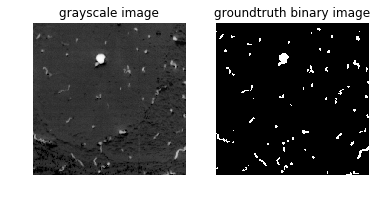

In [2]:
grayscale = scipy.misc.imread("grayscale.png")
grayscale = 255 - grayscale
groundtruth = scipy.misc.imread("groundtruth.png")

plt.subplot(1, 2, 1)
plt.imshow(grayscale, cmap='gray')
plt.title("grayscale image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(groundtruth, cmap='gray')
plt.title("groundtruth binary image")
plt.axis("off")

IMAGE PIXEL INTENSITY HISTOGRAM

Text(0, 0.5, 'Count')

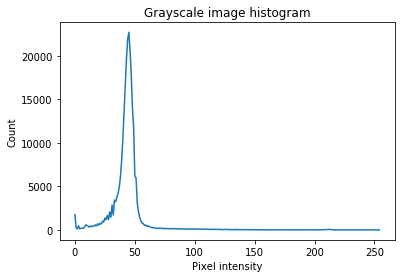

In [3]:
counts, vals = np.histogram(grayscale, bins=range(2 ** 8))

plt.plot(range(0, (2 ** 8) - 1), counts)
plt.title("Grayscale image histogram")
plt.xlabel("Pixel intensity")
plt.ylabel("Count")

# PRE-PROCESSING

Text(0.5, 1.0, 'median filtered image')

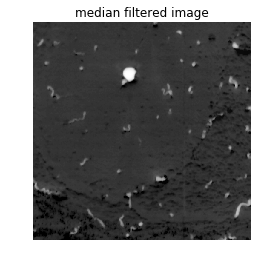

In [ ]:
median_filtered = scipy.ndimage.median_filter(grayscale, size=3)
plt.imshow(median_filtered, cmap='gray')
plt.axis('off')
plt.title("median filtered image")

# SEGMENTATION/THRESHOLDING USING SKIMAGE 

In [ ]:
result = skimage.filters.thresholding.try_all_threshold(median_filtered)

1. Otsu threshold - The algorithm assumes that the image contains two classes of pixels following bi-modal histogram (foreground pixels and background pixels), it then calculates the optimum threshold separating the two classes so that their combined spread (intra-class variance) is minimal, or equivalently (because the sum of pairwise squared distances is constant), so that their inter-class variance is maximal

In [ ]:
threshold = skimage.filters.threshold_otsu(median_filtered)
print("Threshold value is {}".format(threshold))
predicted = np.uint8(median_filtered > threshold) * 255
plt.imshow(predicted, cmap='gray')
plt.axis('off')
plt.title("otsu predicted binary image")

# VALIDATION METRICS

Takeaway - Matthew Correlation Coefficient -https://lettier.github.io/posts/2016-08-05-matthews-correlation-coefficient.html

In [ ]:
def get_validation_metrics(groundtruth, predicted):
    """
    Return validation metrics dictionary with accuracy, f1 score, mcc after
    comparing ground truth and predicted image

    :param groundtruth binary image array
    :param predicted binary image array
    :return returns a dictionary with accuracy,f1 score, tp, tn, fp, fn, and mcc as keys
    """
    groundtruth = (groundtruth).flatten().tolist()
    predicted = (predicted).flatten().tolist()
    validation_metrics = {}
    
    # If all elements are non zero class i.e foreground
    if np.unique(groundtruth).tolist() == np.unique(predicted).tolist() == [1]:
        tn, fp, fn, tp = 0, 0, 0, len(groundtruth)
        f1_score = 1
    # if all elements are zero class i.e background
    elif np.unique(groundtruth).tolist() == np.unique(predicted).tolist() == [0]:
        tn, fp, fn, tp = len(groundtruth), 0, 0, 0
        f1_score = 1
    else:
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth, predicted).ravel()
        f1_score = 2 * tp / ((2 * tp) + fp + fn)
    
    validation_metrics["f1_score"] = f1_score
    
    tn = np.float64(tn)
    fp = np.float64(fp)
    fn = np.float64(fn)
    tp = np.float64(tp)
    
    validation_metrics["tp"] = tp
    validation_metrics["fp"] = fp
    validation_metrics["fn"] = fn
    validation_metrics["tn"] = tn
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    validation_metrics["accuracy"] = accuracy
    
    # edge cases
    if (fp == 0 and fn == 0):
        mcc = 1
    elif (tp == 0 and tn == 0):
        mcc = -1
    elif (tp == 0 and fp == 0):
        mcc = 0
    elif (tp == 0 and fn == 0):
        mcc = 0
    elif (tn == 0 and fp == 0):
        mcc = 0
    elif (tn == 0 and fn == 0):
        mcc = 0
    else:
        mcc = ((tp * tn) - (fp * fn)) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
           
    validation_metrics["mcc"] = mcc
    return validation_metrics

In [ ]:
validation_metrics = get_validation_metrics(groundtruth, predicted)
print("Validation Metrics comparing Otsu and ground truth")
print(validation_metrics)

# VALIDATION VISUALIZATION

In [ ]:
# Confusion matrix overlay masks where TP, FP, FN, TN columns in the masks are in different colors

def get_confusion_matrix_intersection_mats(groundtruth, predicted):
    """
    Returns a dictionary of 4 boolean numpy arrays containing True at TP, FP, FN, TN.
    """
    confusion_matrix_arrs = {}

    groundtruth_inverse = np.logical_not(groundtruth)
    predicted_inverse = np.logical_not(predicted)

    confusion_matrix_arrs["tp"] = np.logical_and(groundtruth, predicted)
    confusion_matrix_arrs["tn"] = np.logical_and(groundtruth_inverse, predicted_inverse)
    confusion_matrix_arrs["fp"] = np.logical_and(groundtruth_inverse, predicted)
    confusion_matrix_arrs["fn"] = np.logical_and(groundtruth, predicted_inverse)

    return confusion_matrix_arrs


def get_confusion_matrix_overlaid_mask(image, groundtruth, predicted, alpha, colors):
    """
    Returns overlay the 'image' with a color mask where TP, FP, FN, TN are
    each a color given by the 'colors' dictionary
    """
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    masks = get_confusion_matrix_intersection_mats(groundtruth, predicted)
    color_mask = np.zeros_like(image)

    for label, mask in masks.items():
        color = colors[label]
        mask_rgb = np.zeros_like(image)
        mask_rgb[mask != 0] = color
        color_mask += mask_rgb

    return cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)

In [ ]:
alpha = 0.5
confusion_matrix_colors = {
   "tp": (0, 255, 255),  #cyan
   "fp": (255, 0, 255),  #magenta
   "fn": (255, 255, 0),  #yellow
   "tn": (0, 0, 0)     #black
   }

validation_mask = get_confusion_matrix_overlaid_mask(grayscale, groundtruth, predicted, alpha, confusion_matrix_colors)
print("Cyan - TP")
print("Magenta - FP")
print("Yellow - FN")
print("Black - TN")

plt.imshow(validation_mask)
plt.axis('off')
plt.title("confusion matrix overlay mask")

In [ ]:
ZEROS_ARRAY = np.zeros((3, 3), dtype=np.uint8)
ONES_ARRAY = np.ones((3, 3), dtype=np.uint8)
ORIGINAL = np.array(([1, 0, 1], [0, 1, 1], [0, 0, 0]), dtype=np.uint8)
PREDICTED = np.array(([1, 0, 1], [0, 0, 1], [1, 0, 0]), dtype=np.uint8)

In [ ]:
def test_get_validation_metrics():
    validation_metrics = get_validation_metrics(ZEROS_ARRAY, ONES_ARRAY)
    nose.tools.assert_equal(validation_metrics["f1_score"], 0)
    nose.tools.assert_equal(validation_metrics["mcc"], -1)

    validation_metrics = get_validation_metrics(ONES_ARRAY, ONES_ARRAY)
    nose.tools.assert_equal(validation_metrics["f1_score"], 1)
    nose.tools.assert_equal(validation_metrics["mcc"], 1)
    
    validation_metrics = get_validation_metrics(ZEROS_ARRAY, ZEROS_ARRAY)
    nose.tools.assert_equal(validation_metrics["f1_score"], 1)
    nose.tools.assert_equal(validation_metrics["mcc"], 1)
    
    validation_metrics = get_validation_metrics(ONES_ARRAY, ZEROS_ARRAY)
    nose.tools.assert_equal(validation_metrics["f1_score"], 0)
    nose.tools.assert_equal(validation_metrics["mcc"], -1)
    
    validation_metrics = get_validation_metrics(ORIGINAL, ORIGINAL)
    nose.tools.assert_equal(validation_metrics["f1_score"], 1)
    nose.tools.assert_equal(validation_metrics["accuracy"], 1)
    nose.tools.assert_equal(validation_metrics["mcc"], 1)
    
    validation_metrics = get_validation_metrics(ORIGINAL, PREDICTED)
    nose.tools.assert_almost_equal(validation_metrics["f1_score"], 0.75, places=3)
    nose.tools.assert_equal(validation_metrics["tp"], 3.0)
    nose.tools.assert_equal(validation_metrics["fp"], 1.0)
    nose.tools.assert_equal(validation_metrics["fn"], 1.0)
    nose.tools.assert_equal(validation_metrics["tn"], 4.0)


test_get_validation_metrics()

In [ ]:
def test_get_confusion_matrix_intersection_mats():
    confusion_matrix_mats = get_confusion_matrix_intersection_mats(ORIGINAL, PREDICTED)
    nose.tools.assert_equal(confusion_matrix_mats["tp"].sum(), 3.0)
    nose.tools.assert_equal(confusion_matrix_mats["fp"].sum(), 1.0)
    nose.tools.assert_equal(confusion_matrix_mats["fn"].sum(), 1.0)
    nose.tools.assert_equal(confusion_matrix_mats["tn"].sum(), 4.0)

test_get_confusion_matrix_intersection_mats()

In [ ]:
def test_get_confusion_matrix_overlaid_mask():
    confusion_matrix_mask = get_confusion_matrix_overlaid_mask(ORIGINAL, ORIGINAL, PREDICTED, alpha, confusion_matrix_colors)
    expected = [0, 128, 128, 0, 0, 0, 0, 128, 128, 0, 0, 0, 128, 128, 0, 0, 128, 128, 128, 0, 128, 0, 0, 0, 0, 0, 0]
    np.testing.assert_array_equal(confusion_matrix_mask.flatten().tolist(), expected)

    
test_get_confusion_matrix_overlaid_mask()